In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from matplotlib import cm
from scipy.integrate import ode 
from kuramoto import * # import the kuramoto classes from file 
from utils import *
from scipy import stats, optimize
from matplotlib import cm

## This notebook contains code for both running the simulation and plotting the data. To run the simulations, run all the cells. To plot the data with the saved .npy files, simply run the cells that load the data, followed by the cells that plot them. 

## First, we do some 1D simulations.  

In [2]:
# Set up model parameters 
epsilon = 1
eta = -0.44
sigmas = [0.01, 0.1, 0.3, 0.45, 0.6]
mean_omega = 0


# Set up simulation parameters 
L = 160
T = 5e4 # total time of the simulation 
n_frames = T # number of time points recorded in the end 
grad = 1.3
grads = [-grad, grad]
seed = 30 

data = [] 
omegas = [] 
models = [] 


for sigma in sigmas:
    # Initialise the model and run the simulation 
    init = np.zeros(L)
    model = Kuramoto(epsilon, eta, sigma, mean_omega, BC='grad', grad=grads)
    model.initialise(L, T, n_frames, init=init, seed=seed) 
    model.evolve() # this runs the simulation, set verbose to True to see output at every time step 
    
    phases = np.copy(model.res[-1]) % (2*np.pi)
    shift(phases)
    data.append(phases)
    omegas.append(model.omegas)
    models.append(model)

100%|████████████████████████████████████| 50000/50000 [06:56<00:00, 119.93it/s]


slope:  0.13075720902139812
slope:  0.2745289065994134
slope:  0.5902501385239157
slope:  0.6730908763125896
slope:  0.7437144235422324


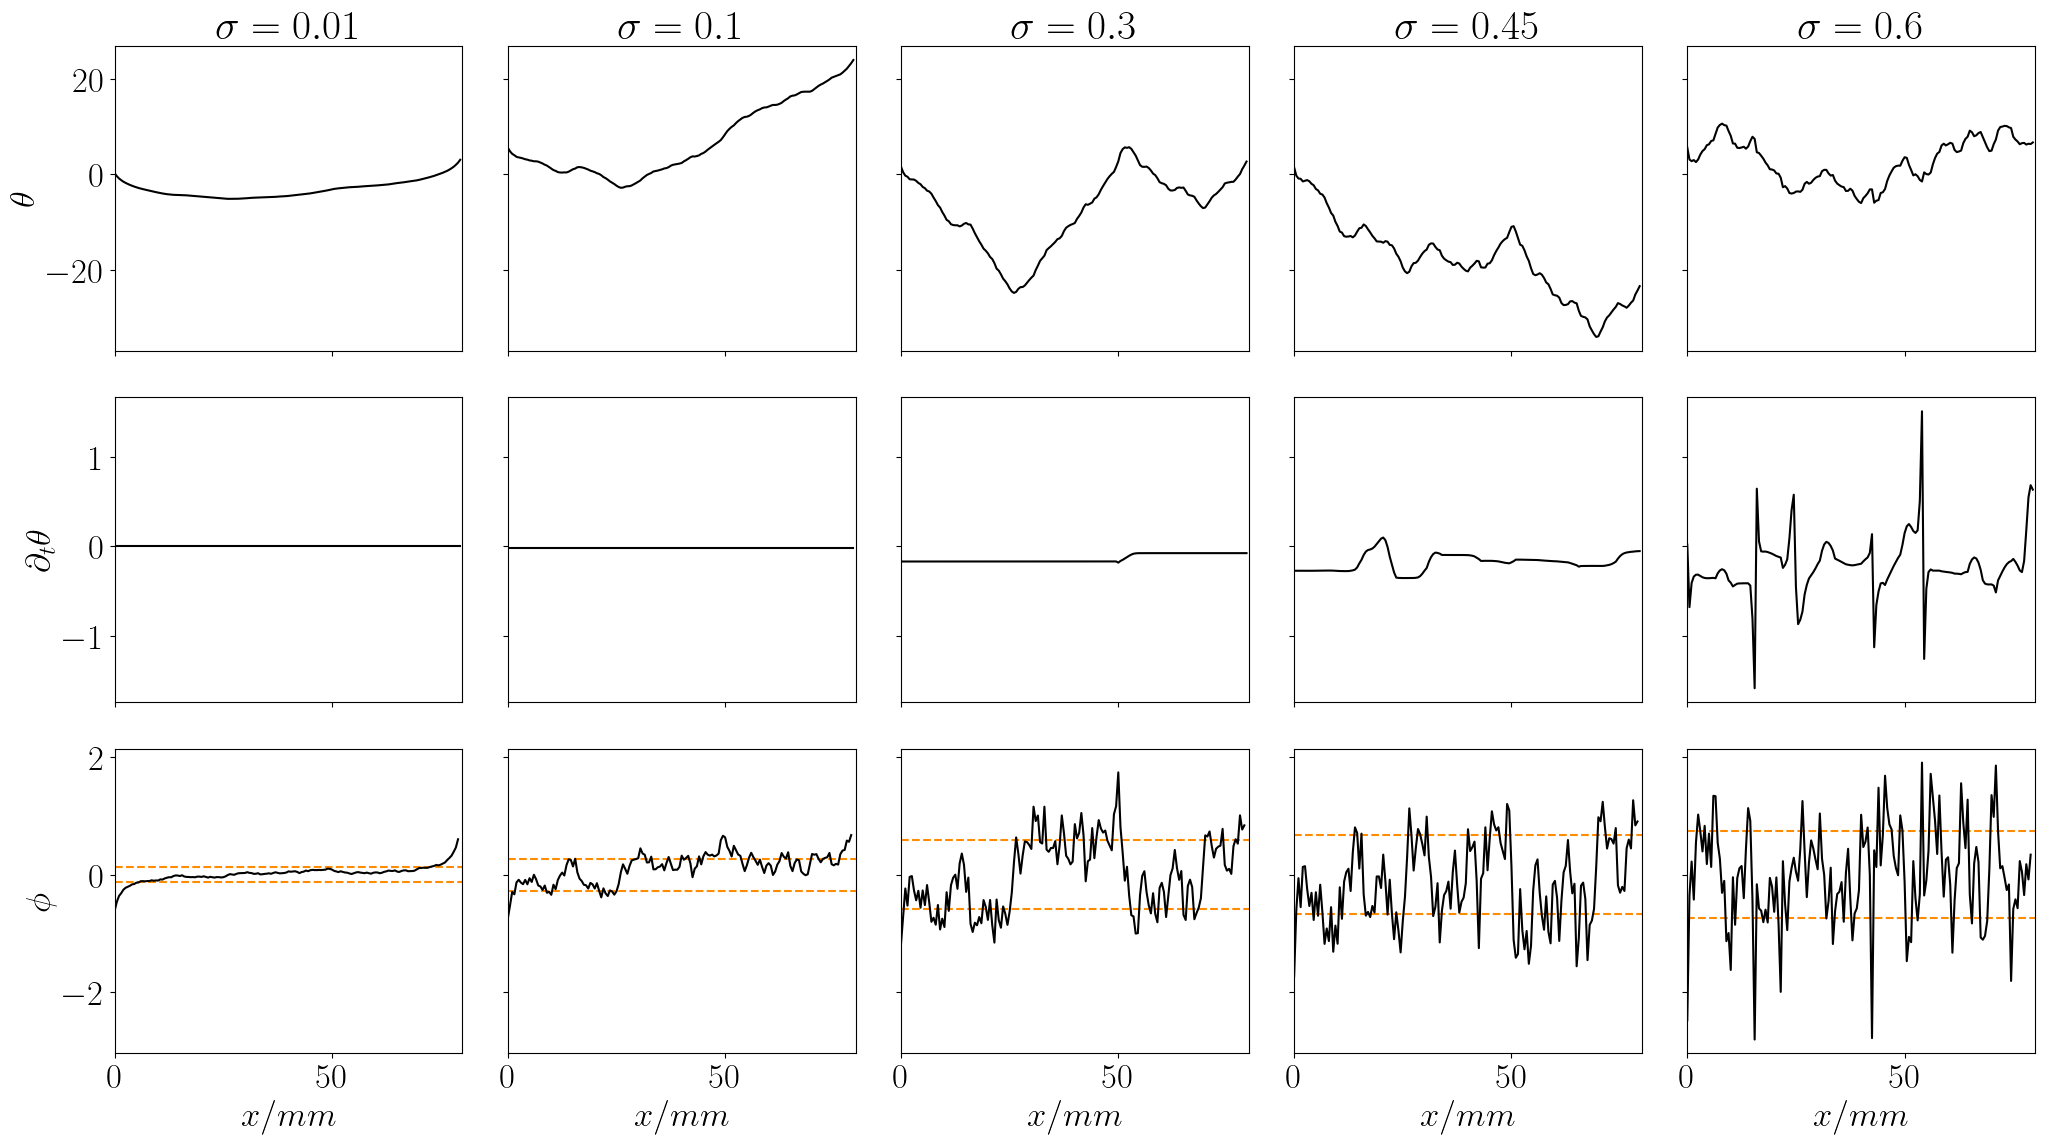

In [6]:
f = 5

plt.rc('text', usetex=True)
plt.rc('font', size=25, family='serif')
fig, axes = plt.subplots(3, len(sigmas[:f]), sharey='row', sharex=True, figsize=(4*len(sigmas[:f])+1, 12))
x = np.arange(L)*0.5

for (i, sigma) in enumerate(sigmas[:f]):
    axes[0, i].plot(x, data[i], 'k-')    
    axes[1, i].plot(x, models[i]._det_rhs(data[i]), 'k-')
    
    v = data[i][1:]-data[i][:-1]
    s = np.sqrt(2*np.mean(1-np.cos(v)))
    axes[2, i].axhline(y=s, color='darkorange', linestyle='--')
    axes[2, i].axhline(y=-s, color='darkorange', linestyle='--')
    axes[2, i].plot(x[:-1], v, 'k-')
    axes[2, i].set_xlabel(r'$x/mm$')
    print('slope: ', s)
    axes[0, i].set_title(r'$\sigma={}$'.format(sigmas[i]))
    

axes[0, 0].set_ylabel(r'$\theta$')
axes[1, 0].set_ylabel(r'$\partial_t \theta $')
axes[2, 0].set_ylabel(r'$\phi$')
plt.xlim([0, L/2])
plt.savefig('Figures/sim.pdf')
plt.tight_layout()
plt.show() 

## Multiple simulations of the MAP parameters 

In [66]:
epsilon = 1
eta = -0.44
sigma = 0.45
mean_omega = 0


# Set up simulation parameters 
L = 160
T = 1e5 # total time of the simulation 
n_frames = T # number of time points recorded in the end 
grad = 1.3
grads = [-grad, grad]


seeds = [1, 10, 100, 1000, 10000]  

data = [] 
omegas = [] 


for seed in seeds: 
    # Initialise the model and run the simulation 
    init = np.zeros(L)
    model = Kuramoto(epsilon, eta, sigma, mean_omega, BC='grad', grad=grads)
    model.initialise(L, T, n_frames, init=init, seed=seed) 
    model.evolve() # this runs the simulation, set verbose to True to see output at every time step 
    
    phases = np.copy(model.res[-1]) % (2*np.pi)
    shift(phases)
    data.append(phases)
    omegas.append(model.omegas) 

100%|██████████| 100000/100000 [07:29<00:00, 222.34it/s]


In [64]:
np.save('Sims/data_sigma={}_eta={}_samples.npy'.format(sigma, eta), data)

In [2]:
eta = -0.44
sigma = 0.45
data = np.load('Sims/data_sigma={}_eta={}_samples.npy'.format(sigma, eta))

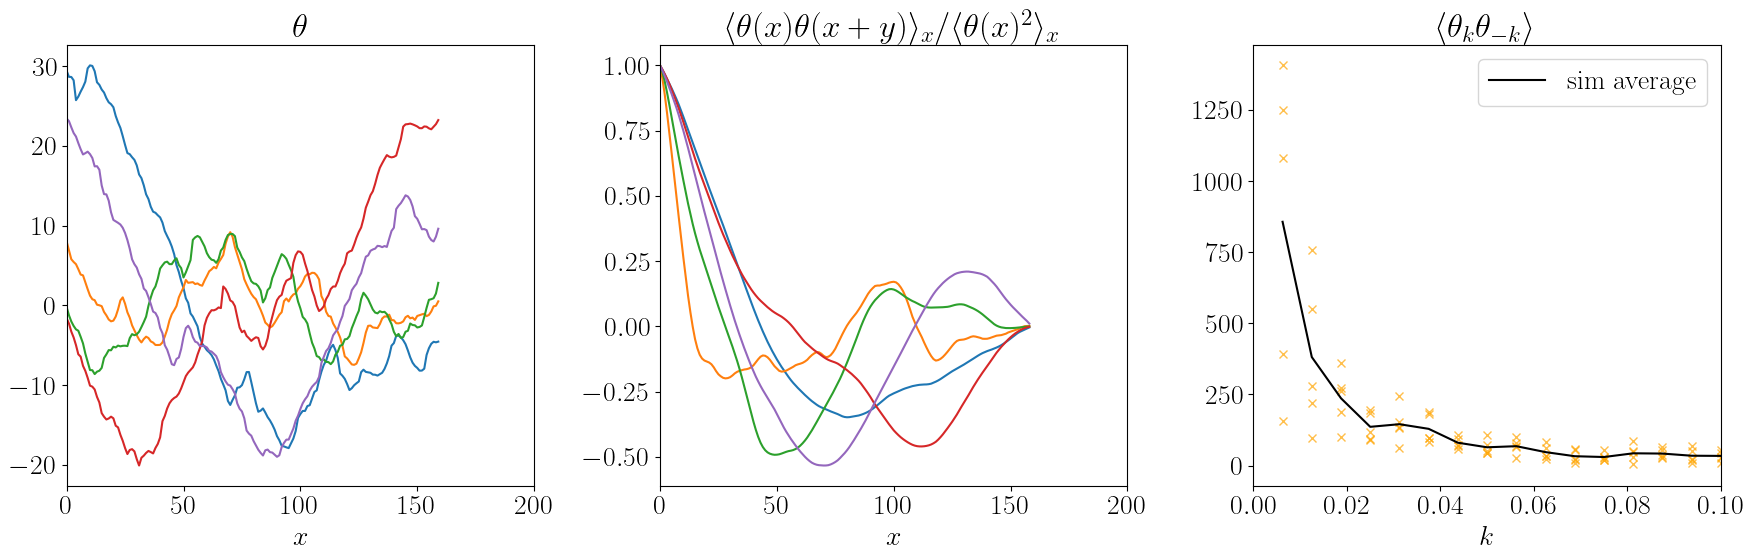

In [6]:
# replot the best fit parameters 
theta_ks = [] 

plt.rc('text', usetex=True)
plt.rc('font', size=20, family='serif')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for (n, theta) in enumerate(data): 
    theta = theta - np.mean(theta)
    axes[0].plot(theta, color=plt.cm.tab10(n))

    L = len(theta)
    corr = np.correlate(theta, theta, mode='full')
    axes[1].plot(corr[L:]/corr[L], color=plt.cm.tab10(n))


    freq = np.fft.rfftfreq(L)[1:]
    theta_k = np.abs(np.fft.rfft(theta))[1:]
    axes[2].plot(freq, theta_k, 'x', color='orange', alpha=0.7)
    theta_ks.append(theta_k)
    i += 1
        
    
m = np.mean(theta_ks, axis=0)
axes[2].plot(freq, m, color='black', label='sim average')
axes[2].legend()

axes[0].set_xlim([0, 200])
axes[1].set_xlim([0, 200])
axes[2].set_xlim([0, 0.1])
axes[0].set_xlabel(r'$x$')
axes[1].set_xlabel(r'$x$')
axes[2].set_xlabel(r'$k$')

axes[0].set_title(r'$\theta$')
axes[1].set_title(r'$\langle \theta(x)\theta(x+y) \rangle_x / \langle \theta(x)^2 \rangle_x $')
axes[2].set_title(r'$\langle \theta_k \theta_{-k} \rangle $')
plt.tight_layout()
plt.show() 

slope:  0.712079115759401
slope:  0.5959831880338141
slope:  0.6677206755486206
slope:  0.7136996847880271
slope:  0.6822622543954272


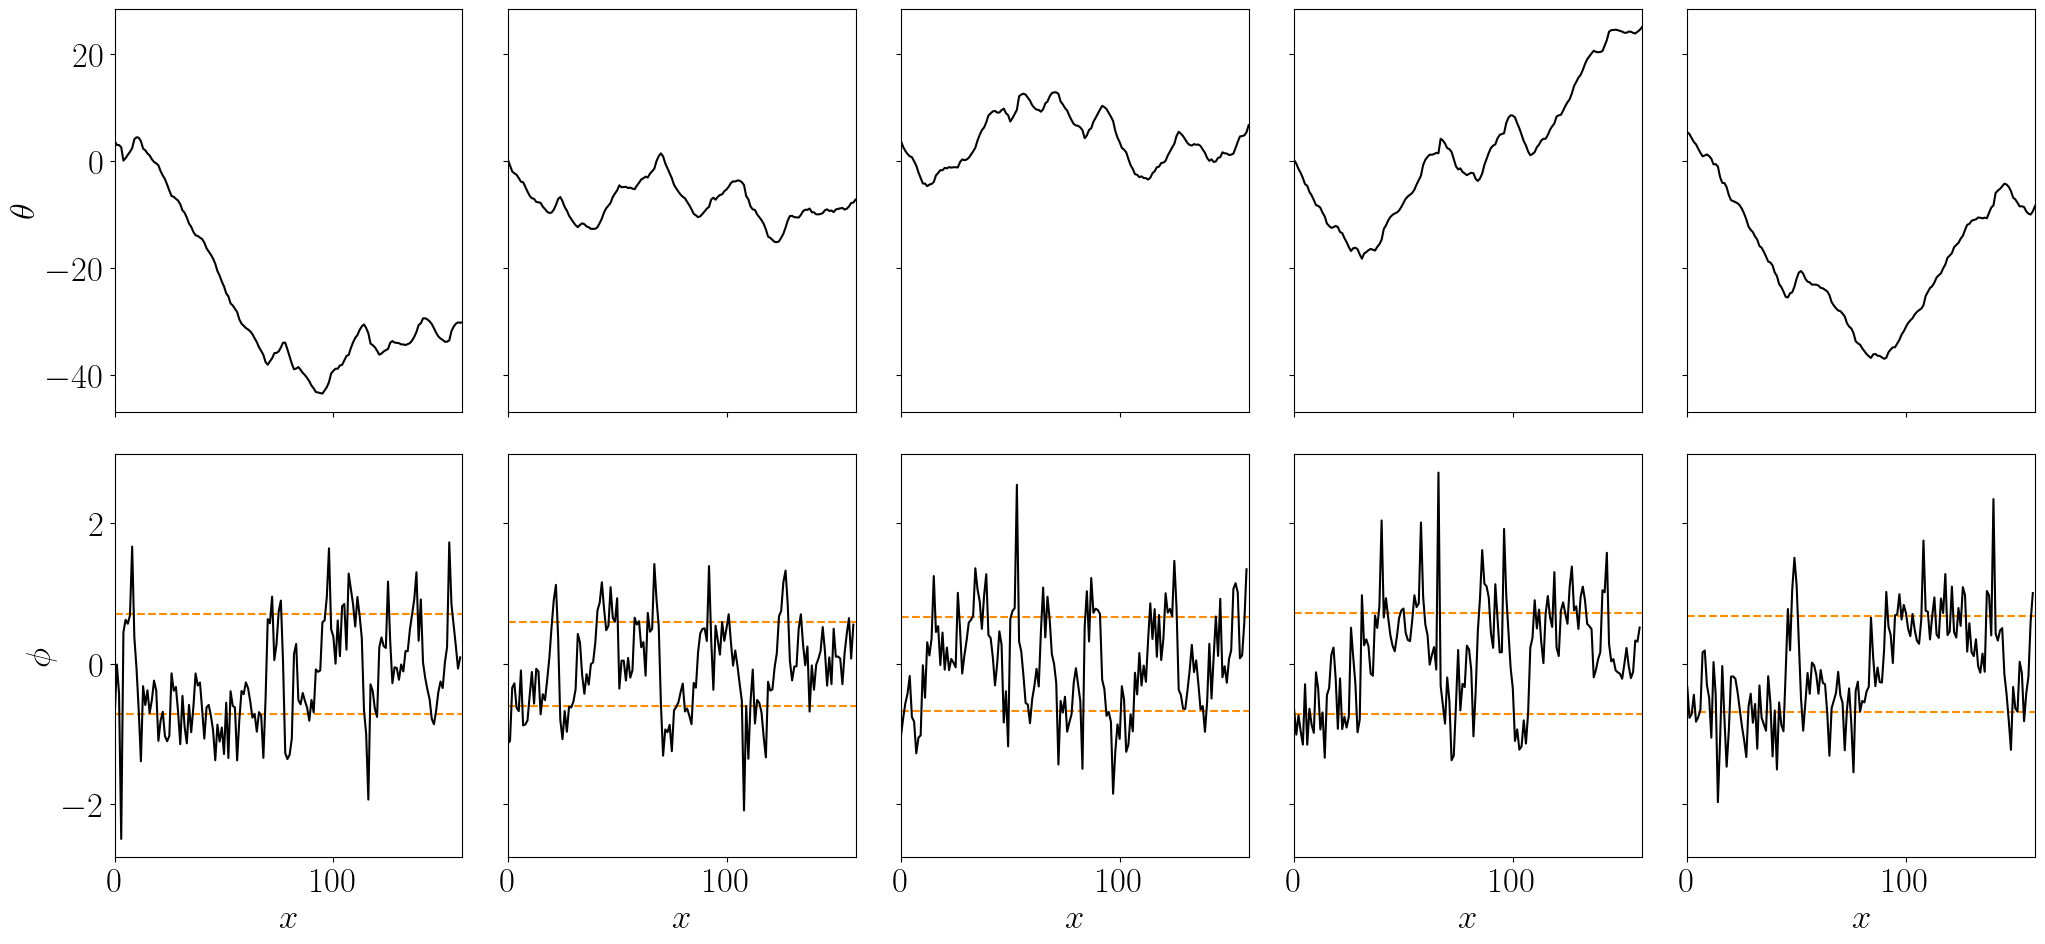

In [3]:
f = 5
L = 160

plt.rc('text', usetex=True)
plt.rc('font', size=25, family='serif')
fig, axes = plt.subplots(2, f, sharey='row', sharex=True, figsize=(4*f+1, 10))

for i in range(f):
    axes[0, i].plot(data[i], 'k-')    

    v = data[i][1:]-data[i][:-1]
    s = np.sqrt(2*np.mean(1-np.cos(v)))
    axes[1, i].axhline(y=s, color='darkorange', linestyle='--')
    axes[1, i].axhline(y=-s, color='darkorange', linestyle='--')
    axes[1, i].plot(v, 'k-')
    axes[1, i].set_xlabel(r'$x$')
    print('slope: ', s)
    

axes[0, 0].set_ylabel(r'$\theta$')
axes[1, 0].set_ylabel(r'$\phi$')
plt.xlim([0, L-1])
plt.tight_layout()
plt.savefig('Figures/map_sim.pdf')
plt.show() 

/var/folders/r6/__jr4p7d52gfcfmwst3psfj80000gn/T/ipykernel_43042/377679058.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('copper')


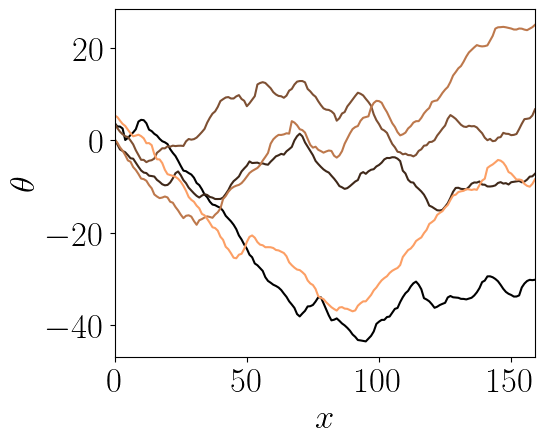

In [7]:
cmap = cm.get_cmap('copper')
fig = plt.figure(figsize=(6, 5))
plt.rc('text', usetex=True)
plt.rc('font', size=25, family='serif')

for i in range(f):
    plt.plot(data[i], color=cmap(i/f))    

plt.ylabel(r'$\theta$')
plt.xlim([0, L-1])
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig('Figures/map_sim_overlap.pdf')
plt.show() 

## Kymograph 

In [13]:
epsilon = 1
eta = -0.44
sigma = 0.09
mean_omega = 0
seed= 30

# Set up simulation parameters 
L = 200
T = 1e3 # total time of the simulation 
n_frames = T*10 # number of time points recorded in the end 
grad = 1.3
grads = [-grad, grad]
init = np.zeros(L) + np.pi*np.random.normal(size=L)

model = Kuramoto(epsilon, eta, sigma, mean_omega, BC='grad', grad=grads)
model.initialise(L, T, n_frames, init=init, seed=seed) 
model.evolve() 
res = model.res % (2*np.pi)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 15501.86it/s]


In [146]:
np.save('Sims/data_sigma={}_eta={}.npy'.format(sigma, eta), res)

In [8]:
eta = -0.44
sigma = 0.45
res = np.load('Sims/data_sigma={}_eta={}.npy'.format(sigma, eta)) %(2*np.pi)

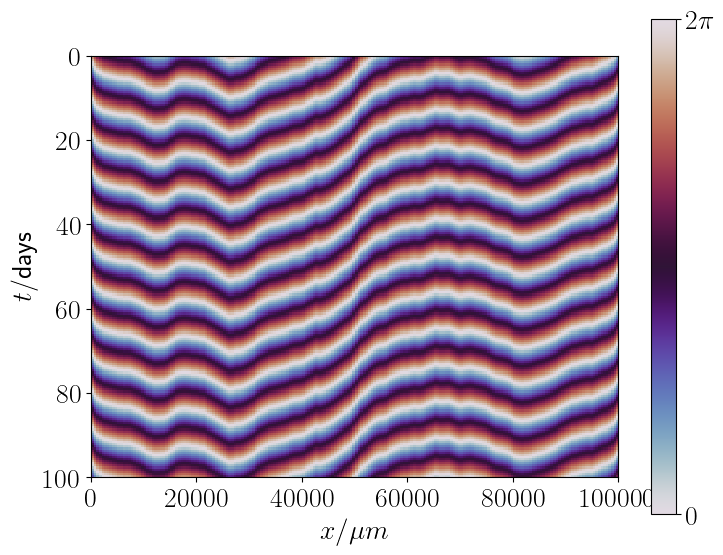

In [14]:
N = 200
epsilon = 0.2
scale= 10
omega_extra = 2*np.pi/8.6/epsilon/scale

phases = np.copy(res[-N:, :])
phases += np.arange(N)[:, np.newaxis]*omega_extra

plt.figure(figsize=(8, 6))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
im = plt.imshow(phases %(2*np.pi), cmap='twilight', interpolation='none', vmin=0, vmax=2*np.pi, extent=[0, L*500, N/scale/epsilon, 0], aspect=800)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.xlabel(r'$x/\mu m$')
plt.ylabel(r'$t$/days')
plt.tight_layout()
plt.show() 